<a href="https://colab.research.google.com/github/1000century/InterviewAnswer/blob/main/v3_vqa_b16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install korouge_score -qq
! pip install bert_score -qq

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

# Data Preprocessing

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_343176.json: Invalid control character at: line 23 column 433 (char 1029)
Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_178194.json: Invalid control character at: line 23 column 135 (char 755)
Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_269424.json: Invalid control character at: line 23 column 571 (char 1132)
Error reading /kaggle/working/train_unzipped/TL_05.ICT_Male_New/ckmk_d_ict_m_n_337139.json: Expecting property name enclosed in double quotes: line 22 column 21 (char 576)
Error reading /kaggle/working/validation_unzipped/VL_06.Design_Female_Experienced/ckmk_d_ard_f_e_66661.json: Invalid control character at: line 34 column 165 (char 1573)
Error reading /kaggle/working/validation_unzipped/VL_01.Management_Female_New/ckmk_d_bm_f_n_161564.json: Invalid control character at: line 23 column 100 (char 688)

Dataset In

In [ ]:
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel
import torch


In [ ]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>')

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
occupation_map = {
    'SM': '영업마케팅',
    'PS': '공공서비스',
    'RND': '연구개발',
    'ICT': '정보통신',
    'ARD': '디자인',
    'MM': '생산관리',
    'BM': '경영사무'
}
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s>경력상태: {'신입' if exp == 'NEW' else '경력직'} 질문: {q} 답변: {a} </s>"
        for occ, exp, q, a in zip(
            examples["dataSet_info_occupation"],
            examples["dataSet_info_experience"],
            examples["dataSet_question_raw_text"],
            examples["dataSet_answer_raw_text"]
        )
    ]

    tokenized = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': [-100 if token == tokenizer.pad_token_id else token for token in tokenized['input_ids']]
    }

orig_train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

orig_valid_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torch.utils.data import Subset

train_dataset = orig_train_dataset
valid_dataset = orig_valid_dataset
# # 앞에서부터 1000개씩 선택
# train_dataset = Subset(orig_train_dataset, range(100))
# valid_dataset = Subset(orig_valid_dataset, range(100))

print(len(valid_dataset))  # 1000

8026


In [ ]:
def collate_fn(batch):
   input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
   attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
   labels = torch.stack([torch.tensor(item['labels']) for item in batch])

   return {
       'input_ids': input_ids,
       'attention_mask': attention_mask,
       'labels': labels
   }

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# DataLoader에서 배치 샘플 확인
for batch in train_dataloader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
    for i in batch['input_ids']:
        print(i)
        print(tokenizer.decode(i))
        break

    break

Input IDs shape: torch.Size([16, 256])
Attention mask shape: torch.Size([16, 256])
Labels shape: torch.Size([16, 256])
tensor([    1, 12170, 11626,   401, 33442, 24454,   401, 11011,  8159,  7177,
        23916, 17336, 11448, 12016, 25354, 11711,  7285, 11063,  9278, 15468,
        41277, 11114,  9661,  7055,  8084, 12817,  7643,   401, 45887, 11448,
        12016,  9278,  9458, 41277, 21176, 11869, 11711, 21154,  9265, 45887,
         9037, 12388, 30961, 13997,  9450,  9185, 10165, 10925,  9450,  9185,
        15659, 15902, 39315,   739,  7662,  8263, 25585, 11448,  8006, 45758,
        24022,  9355, 11070,  9658,  6903, 11070, 38412, 36676,  9863, 12657,
         9439, 22939,  9443,  9350, 14651, 16691,  9394,  9022, 12388, 21176,
         9322, 13768,  9088,  9834, 11273,  7162,   739,  7662,  9176,  9269,
        11530, 25592, 12371, 11662, 12102, 10413,  9131, 42481, 22939, 18626,
        32240, 11403,  9239, 14594, 16898, 22227,  9919, 23854, 11130, 39840,
         9290, 21681, 1

In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

## Model Train

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from korouge_score import rouge_scorer
from tqdm import tqdm
from bert_score import score  # bert-score import 추가

In [ ]:
# SmoothingFunction 설정
smoothing = SmoothingFunction().method1

# 모델 학습 설정
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 옵티마이저 및 스케줄러 정의
optimizer = AdamW(model.parameters(), lr=5e-5)  # 옵티마이저 정의
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)  # 스케줄러 정의

# ROUGE 계산기
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
best_valid_loss = float('inf')

# 학습 및 검증 루프
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    total_train_loss = 0
    train_steps = 0
    total_train_bleu = 0
    total_train_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_train_samples = 0

    train_pbar = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}')
    for batch in train_pbar:
        # 입력 데이터 준비
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델 출력
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 역전파 및 최적화
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()  # 옵티마이저 업데이트
        scheduler.step()  # 스케줄러 업데이트
        optimizer.zero_grad()
        torch.cuda.empty_cache()  # 여기 추가

        # 손실 누적
        total_train_loss += loss.item()
        train_steps += 1

        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # 평균 점수 계산
    avg_train_loss = total_train_loss / train_steps

    print(f"\nEpoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model.eval()
    total_valid_loss = 0
    valid_steps = 0
    total_valid_bleu = 0
    total_valid_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_valid_samples = 0

    all_generated_texts = []  # BERTScore를 계산하기 위한 생성 텍스트 리스트
    all_reference_texts = []  # BERTScore를 계산하기 위한 참조 텍스트 리스트

    with torch.no_grad():
        valid_pbar = tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}')
        for i, batch in enumerate(valid_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # 손실 누적
            total_valid_loss += loss.item()
            valid_steps += 1

            # BLEU 및 ROUGE 계산
            generated_ids = outputs.logits.argmax(dim=-1)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            labels_for_decoding = labels.masked_fill(labels == -100, tokenizer.pad_token_id)
            reference_texts = tokenizer.batch_decode(labels_for_decoding, skip_special_tokens=True)
            if i ==0:
                for r,g in zip(reference_texts,generated_texts):
                    print(r)
                    print(g)

            all_generated_texts.extend(generated_texts)
            all_reference_texts.extend(reference_texts)

            for ref, gen in zip(reference_texts, generated_texts):
                bleu_score = sentence_bleu([ref.split()], gen.split(), smoothing_function=smoothing)
                total_valid_bleu += bleu_score

                rouge_scores = scorer.score(ref, gen)
                for key in total_valid_rouge.keys():
                    total_valid_rouge[key] += rouge_scores[key].fmeasure
                num_valid_samples +=1

            valid_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            torch.cuda.empty_cache()  # 여기 추가

    # 평균 점수 계산
    avg_valid_loss = total_valid_loss / valid_steps
    avg_valid_bleu = total_valid_bleu / valid_steps
    avg_valid_rouge = {k: v / num_valid_samples for k, v in total_valid_rouge.items()}

    # BERTScore 계산
    P, R, F1 = score(all_generated_texts, all_reference_texts, lang="ko", verbose=True)  # lang="ko"는 한국어 기준

    print(f"Epoch {epoch+1} Average Validation Loss: {avg_valid_loss:.4f}")
    print(f"Epoch {epoch+1} Average Validation BLEU: {avg_valid_bleu:.4f}")
    print(f"Epoch {epoch+1} Average Validation ROUGE: {avg_valid_rouge}")
    print(f"Epoch {epoch+1} BERTScore Precision: {P.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore Recall: {R.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore F1: {F1.mean():.4f}")

    # 최적의 모델 저장
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        print(f"Saving best model with validation loss: {best_valid_loss:.4f}")
        torch.save(model.state_dict(), './best_model.pt')  # 현재 디렉토리에 저장

print("\nTraining completed!")


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 4255/4255 [1:29:52<00:00,  1.27s/it, loss=2.0983]



Epoch 1 Average Training Loss: 2.4002


Validation Epoch 1:   0%|          | 1/502 [00:00<04:42,  1.77it/s, loss=2.9205]

경력상태: 신입 질문: 해당 직무와 관련한 자신이 강점이라고 생각하시는 것에 대해 경험을 빗대어 어떤 경험이 있으신지 어 그런 것들을 해서 세부적으로 말씀해 주시기 바랍니다 답변: 해외 직무와 관련한 저만의 강점이라고 한다면 저는 해외 쪽 인원들과 관련된 어 해외 언어 능력이라고 말씀드릴 수 있겠습니다. 저의 경우는 중국 상해 지역에 오 년 동안 유학생활을 경험을 했으며 그 영업 동안 유학생활 동안 일본어와 영어를 같이 공부를 해서 자유 어느정도 자유자재로 어 구사할 정도의 수준을 가지고 있습니다. 특히 언어 뿐만이 아니라 이 년 이 년 간은 신 심천사무소에서 지사장으로 로컬 영업을 진행을 하였으며 신규 영업을 창출하고 미수금까지 회수하는 지사장 팀 리더로서 근무를 한 경험을 가지고 있습니다. 물론 저보다 중국어나 다른 외국어를 잘하는 인원들은 많을 것이라 생각을 합니다. 하지만 해외 해외 영업에서 가장 중요한 무에서 유를 창출해서 영업 매출로 이어지고 그런 부분들을 직접 미수금까지 챙기는 일련의 과정들을 경험한 경험해 본 사람은 많지 않으리라 생각을 합니다. 따라서 저의 강점은 무에서 유를 창출해내는 영업 매출을 일으키는 능력이라 할 수 있겠습니다. 
경력상태: 신입 질문: 지원 직무에 관련된 일을 있이나 생각하는하시는지 대해서 설명해 말씀대어 설명해 식으로 있는지으신가 말씀 설명해 경험을 자세하게 설명해적으로 설명해해 주시시기 바랍니다 답변: 저 영업에 관련된 저의 강이라면 한다면 저는 어 영업을 업무를들과 소통 일을 일을 어들을이라고 생각드릴 수 있겠습니다. 어는 장점은 어어를에서 있는 년 동안 거주 생활을 해 해 상해 당시에과 중국 생활 동안 어 중국 중국 사용 구사 했 어자 정도 의사소자재로 구사 의사소할 수 실력을 가지고 있습니다. 그리고 중국적인만이 아니라 어 언어 동안 년 동안 중국에서 중국 남방천 지역에서소에서 어장을 근무칼 영업을 진행을 하면서 그 영업 진행을하는 신규금 회수 회수하는 등장으로서 역할을장으로서로서 역할을 하였 경험이 가지고 있

Validation Epoch 1: 100%|██████████| 502/502 [04:13<00:00,  1.98it/s, loss=2.4675]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 282.10 seconds, 28.45 sentences/sec
Epoch 1 Average Validation Loss: 2.1743
Epoch 1 Average Validation BLEU: 0.9069
Epoch 1 Average Validation ROUGE: {'rouge1': 0.35753406833194634, 'rouge2': 0.10468031610918326, 'rougeL': 0.2836929023698022}
Epoch 1 BERTScore Precision: 0.7810
Epoch 1 BERTScore Recall: 0.7703
Epoch 1 BERTScore F1: 0.7756
Saving best model with validation loss: 2.1743


Training Epoch 2: 100%|██████████| 4255/4255 [1:30:00<00:00,  1.27s/it, loss=1.8940]



Epoch 2 Average Training Loss: 2.2077


Validation Epoch 2:   0%|          | 1/502 [00:00<04:35,  1.82it/s, loss=2.8579]

경력상태: 신입 질문: 해당 직무와 관련한 자신이 강점이라고 생각하시는 것에 대해 경험을 빗대어 어떤 경험이 있으신지 어 그런 것들을 해서 세부적으로 말씀해 주시기 바랍니다 답변: 해외 직무와 관련한 저만의 강점이라고 한다면 저는 해외 쪽 인원들과 관련된 어 해외 언어 능력이라고 말씀드릴 수 있겠습니다. 저의 경우는 중국 상해 지역에 오 년 동안 유학생활을 경험을 했으며 그 영업 동안 유학생활 동안 일본어와 영어를 같이 공부를 해서 자유 어느정도 자유자재로 어 구사할 정도의 수준을 가지고 있습니다. 특히 언어 뿐만이 아니라 이 년 이 년 간은 신 심천사무소에서 지사장으로 로컬 영업을 진행을 하였으며 신규 영업을 창출하고 미수금까지 회수하는 지사장 팀 리더로서 근무를 한 경험을 가지고 있습니다. 물론 저보다 중국어나 다른 외국어를 잘하는 인원들은 많을 것이라 생각을 합니다. 하지만 해외 해외 영업에서 가장 중요한 무에서 유를 창출해서 영업 매출로 이어지고 그런 부분들을 직접 미수금까지 챙기는 일련의 과정들을 경험한 경험해 본 사람은 많지 않으리라 생각을 합니다. 따라서 저의 강점은 무에서 유를 창출해내는 영업 매출을 일으키는 능력이라 할 수 있겠습니다. 
경력상태: 신입 질문: 지원 직무에 관련 일을 있이나 생각하는하십지 대해 말씀 말씀대어 설명해 식으로 있으신가 말씀 설명해 경험을 설명해 설명해적으로 설명해해 주시시기 바랍니다 답변: 저 영업에 관련된 저의 강점이라고 한다면 저는 어 영업 관련된들과 소통 업무를 영어 영업들을이라고 생각드리고 수 있을습니다. 저는 경우는 어어를에서 있는 년간 동안 유학 생활을 했 했 그 당시에에 해외 생활 동안 중국 호주 중국어 자유롭게 구사 했 중국자 정도 의사소자재로 구사 구사할 수 실력을 가지고 있습니다. 그리고 중국적인만이 아니라 중국어 중국 동안 년 동안 중국에서 중국어 남방천이라는소에서 근무를장으로 근무 근무 영업을 진행을 하면서 그 영업 진행을하는 신규금 회수 처리하는하는 등장으로서 역할을장로서 어 하였 경험이 가지

Validation Epoch 2: 100%|██████████| 502/502 [04:14<00:00,  1.97it/s, loss=2.4281]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 280.84 seconds, 28.58 sentences/sec
Epoch 2 Average Validation Loss: 2.1352
Epoch 2 Average Validation BLEU: 0.9555
Epoch 2 Average Validation ROUGE: {'rouge1': 0.36236436307108677, 'rouge2': 0.10847532377880546, 'rougeL': 0.28901130195701036}
Epoch 2 BERTScore Precision: 0.7837
Epoch 2 BERTScore Recall: 0.7732
Epoch 2 BERTScore F1: 0.7784
Saving best model with validation loss: 2.1352


Training Epoch 3: 100%|██████████| 4255/4255 [1:30:06<00:00,  1.27s/it, loss=2.3614]



Epoch 3 Average Training Loss: 2.1036


Validation Epoch 3:   0%|          | 1/502 [00:00<04:37,  1.81it/s, loss=2.8334]

경력상태: 신입 질문: 해당 직무와 관련한 자신이 강점이라고 생각하시는 것에 대해 경험을 빗대어 어떤 경험이 있으신지 어 그런 것들을 해서 세부적으로 말씀해 주시기 바랍니다 답변: 해외 직무와 관련한 저만의 강점이라고 한다면 저는 해외 쪽 인원들과 관련된 어 해외 언어 능력이라고 말씀드릴 수 있겠습니다. 저의 경우는 중국 상해 지역에 오 년 동안 유학생활을 경험을 했으며 그 영업 동안 유학생활 동안 일본어와 영어를 같이 공부를 해서 자유 어느정도 자유자재로 어 구사할 정도의 수준을 가지고 있습니다. 특히 언어 뿐만이 아니라 이 년 이 년 간은 신 심천사무소에서 지사장으로 로컬 영업을 진행을 하였으며 신규 영업을 창출하고 미수금까지 회수하는 지사장 팀 리더로서 근무를 한 경험을 가지고 있습니다. 물론 저보다 중국어나 다른 외국어를 잘하는 인원들은 많을 것이라 생각을 합니다. 하지만 해외 해외 영업에서 가장 중요한 무에서 유를 창출해서 영업 매출로 이어지고 그런 부분들을 직접 미수금까지 챙기는 일련의 과정들을 경험한 경험해 본 사람은 많지 않으리라 생각을 합니다. 따라서 저의 강점은 무에서 유를 창출해내는 영업 매출을 일으키는 능력이라 할 수 있겠습니다. 
경력상태: 신입 질문: 지원 직무에 관련된 일을 있이나 생각하는하시는지 대해 말씀 말씀대어 말씀 식으로 있는지으신지 말씀 말씀 경험을 말씀 설명해적으로 설명해해 주시시기 바랍니다 답변: 저 영업에 관련된 저의 강이라고 생각하는 저는 어 영업 관련된들과 소 업무를 업무를 영업들을들을 생각드리고 수 있겠습니다. 어는 경우는 어어를에서 있는 년간 동안 유학 생활을 진행을 했 그 당시에적인 어 생활 동안 어어와 영어를 자유롭게 사용할 했 어자 정도 의사소자재로 구사 구사할 수 능력을 가지고 있습니다. 그리고 중국적인만이 아니라 중국 중국 동안 년 동안 미국에서 중국 중화천 지역에서소에서 어장으로 근무칼 영업을 진행을 하면서 그 영업 진행을하는 신규금 회수 처리하는하는 일련의장으로서 역할을장으로서로서의 역할을 하면서 경

Validation Epoch 3: 100%|██████████| 502/502 [04:13<00:00,  1.98it/s, loss=2.4262]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 281.40 seconds, 28.52 sentences/sec
Epoch 3 Average Validation Loss: 2.1215
Epoch 3 Average Validation BLEU: 0.9942
Epoch 3 Average Validation ROUGE: {'rouge1': 0.36507997175951284, 'rouge2': 0.1110251021735764, 'rougeL': 0.2917105877268452}
Epoch 3 BERTScore Precision: 0.7849
Epoch 3 BERTScore Recall: 0.7757
Epoch 3 BERTScore F1: 0.7802
Saving best model with validation loss: 2.1215


Training Epoch 4: 100%|██████████| 4255/4255 [1:30:02<00:00,  1.27s/it, loss=2.1144]



Epoch 4 Average Training Loss: 2.0253


Validation Epoch 4:   0%|          | 1/502 [00:00<04:36,  1.81it/s, loss=2.8226]

경력상태: 신입 질문: 해당 직무와 관련한 자신이 강점이라고 생각하시는 것에 대해 경험을 빗대어 어떤 경험이 있으신지 어 그런 것들을 해서 세부적으로 말씀해 주시기 바랍니다 답변: 해외 직무와 관련한 저만의 강점이라고 한다면 저는 해외 쪽 인원들과 관련된 어 해외 언어 능력이라고 말씀드릴 수 있겠습니다. 저의 경우는 중국 상해 지역에 오 년 동안 유학생활을 경험을 했으며 그 영업 동안 유학생활 동안 일본어와 영어를 같이 공부를 해서 자유 어느정도 자유자재로 어 구사할 정도의 수준을 가지고 있습니다. 특히 언어 뿐만이 아니라 이 년 이 년 간은 신 심천사무소에서 지사장으로 로컬 영업을 진행을 하였으며 신규 영업을 창출하고 미수금까지 회수하는 지사장 팀 리더로서 근무를 한 경험을 가지고 있습니다. 물론 저보다 중국어나 다른 외국어를 잘하는 인원들은 많을 것이라 생각을 합니다. 하지만 해외 해외 영업에서 가장 중요한 무에서 유를 창출해서 영업 매출로 이어지고 그런 부분들을 직접 미수금까지 챙기는 일련의 과정들을 경험한 경험해 본 사람은 많지 않으리라 생각을 합니다. 따라서 저의 강점은 무에서 유를 창출해내는 영업 매출을 일으키는 능력이라 할 수 있겠습니다. 
경력상태: 신입 질문: 지원 직무에 관련된 일을 가지고이나 생각하는하시는지 대해 말씀 바탕으로대어 말씀 식으로 있는지으신지 말씀 말씀 경험을 설명해 설명해적으로 설명해해 주시시기 바랍니다 답변: 저 영업에 관련된 저의 강이라고 한다면 저는 어 영업 관련된들과 소통 업무를 업무를 쪽들을이라고 생각드리고 수 있겠습니다. 저는 전공 대학교어를에서 있는 년간 동안 유학 생활을 진행을 했 그 당시에 쪽 해외 생활 동안 어어와 영어를 자유롭게 구사 했 어자 정도 의사소자재로 구사 구사할 수 실력을 가지고 있습니다. 그리고 일본적인만이 아니라 중국 언어 동안 년 동안 미국에서 중국 중화천 지역에서소에서 어장으로 근무 근무 영업을 진행을 하면서 그 영업 진행을하는 신규금 회수 처리하는하는 일련의장의 역할을장으로서로서의 역할을

Validation Epoch 4: 100%|██████████| 502/502 [04:14<00:00,  1.97it/s, loss=2.4105]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 282.35 seconds, 28.43 sentences/sec
Epoch 4 Average Validation Loss: 2.1079
Epoch 4 Average Validation BLEU: 1.0156
Epoch 4 Average Validation ROUGE: {'rouge1': 0.3689077260965818, 'rouge2': 0.11276878677805265, 'rougeL': 0.2943877202641383}
Epoch 4 BERTScore Precision: 0.7867
Epoch 4 BERTScore Recall: 0.7777
Epoch 4 BERTScore F1: 0.7821
Saving best model with validation loss: 2.1079


Training Epoch 5: 100%|██████████| 4255/4255 [1:29:59<00:00,  1.27s/it, loss=1.9073]



Epoch 5 Average Training Loss: 1.9668


Validation Epoch 5:   0%|          | 1/502 [00:00<04:37,  1.80it/s, loss=2.8162]

경력상태: 신입 질문: 해당 직무와 관련한 자신이 강점이라고 생각하시는 것에 대해 경험을 빗대어 어떤 경험이 있으신지 어 그런 것들을 해서 세부적으로 말씀해 주시기 바랍니다 답변: 해외 직무와 관련한 저만의 강점이라고 한다면 저는 해외 쪽 인원들과 관련된 어 해외 언어 능력이라고 말씀드릴 수 있겠습니다. 저의 경우는 중국 상해 지역에 오 년 동안 유학생활을 경험을 했으며 그 영업 동안 유학생활 동안 일본어와 영어를 같이 공부를 해서 자유 어느정도 자유자재로 어 구사할 정도의 수준을 가지고 있습니다. 특히 언어 뿐만이 아니라 이 년 이 년 간은 신 심천사무소에서 지사장으로 로컬 영업을 진행을 하였으며 신규 영업을 창출하고 미수금까지 회수하는 지사장 팀 리더로서 근무를 한 경험을 가지고 있습니다. 물론 저보다 중국어나 다른 외국어를 잘하는 인원들은 많을 것이라 생각을 합니다. 하지만 해외 해외 영업에서 가장 중요한 무에서 유를 창출해서 영업 매출로 이어지고 그런 부분들을 직접 미수금까지 챙기는 일련의 과정들을 경험한 경험해 본 사람은 많지 않으리라 생각을 합니다. 따라서 저의 강점은 무에서 유를 창출해내는 영업 매출을 일으키는 능력이라 할 수 있겠습니다. 
경력상태: 신입 질문: 지원 직무에 관련된 일을 있이나 생각하는하시는지 대해 말씀 바탕으로대어 말씀 식으로 있는지으신지 말씀 말씀 경험을 설명해 설명해적으로 설명해해 주시시기 바랍니다 답변: 저 영업에 관련된 저의 강이라고 생각하는 저는 어 영업 관련된들과 소통 업무를 업무를 어들을들을 생각드리고 수 있겠습니다. 저는 경우는 어 상해에서 있는 년간 동안 유학 생활을 진행을 했 그 당시에 쪽 해외 생활 동안 어어와 영어를 자유롭게 구사 했 어자 정도 의사소자재로 구사 구사할 수 능력을 가지고 있습니다. 따라서 일본적인만이 아니라 중국 중국 동안 년 동안 미국에서 미국에서 중화천 지역에서소에서 어장으로 근무 근무 영업을 진행을 하면서 그 영업 진행을하는 신규금 회수 처리하는하는 일련의장의 역할을장으로서로서의 역할을

Validation Epoch 5: 100%|██████████| 502/502 [04:14<00:00,  1.97it/s, loss=2.4115]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 282.31 seconds, 28.43 sentences/sec
Epoch 5 Average Validation Loss: 2.1088
Epoch 5 Average Validation BLEU: 1.0342
Epoch 5 Average Validation ROUGE: {'rouge1': 0.37006119923686803, 'rouge2': 0.11388292672741122, 'rougeL': 0.29512936751560886}
Epoch 5 BERTScore Precision: 0.7867
Epoch 5 BERTScore Recall: 0.7785
Epoch 5 BERTScore F1: 0.7826

Training completed!


In [ ]:
import torch
import gc

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")
#gc.collect()

GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 2760.00 MB
  사용 중인 메모리: 2248.62 MB
  사용 가능 메모리: 511.38 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 0.00 MB
  사용 중인 메모리: 0.00 MB
  사용 가능 메모리: 0.00 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
print(f"GPU 메모리 사용량 (할당): {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"GPU 메모리 사용량 (예약): {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


GPU 메모리 사용량 (할당): 2248.62 MB
GPU 메모리 사용량 (예약): 2760.00 MB


In [ ]:
import gc
gc.collect()

831

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:

--- Response with Pretrained Weights ---
: 자신이 어떻게 하면 돈을 벌 수 있을까요?"
"그렇습니다만, 지금은 모든 것을 할 수 있는 기회를 갖지 못했습니다."
결국 세 번째 질문은 결국 자신의 약점을 들추어내 자신의 부족한 점을 채워 나가는 쪽으로 옮겨갔다.
"자, 오늘은 점심시간인데 여기서 무엇을 먹을까요."
이 질문에서는 가장 우선적인 점심을 먹어라.
그리고 자신이 좋아하는 것은 무엇이든지 먹고 싶지 않은 사람은 아무 것도 먹지 말라는 것이었다.
자신처럼 약한 사람은 결코 먹지 말라.
그러면 약점만큼은 과감하게 버린다.
그리고 그 약점은 자기 마음대로 되지 않도록 자신의 단점을 채워 나가야 한다.
오늘은 햄버거와 함께 식사를 했다.
점심은 쉐프와 함께 했다.
첫 번째 질문을 할 때는 뭔가 잘못한 것이 있으면 지적해 주지 않을까 싶은 생각에 기분이 상했는데, 두번째 질문에는 아주 기분 좋게 웃으면서 대답을 하였다.
그 후 두번째 질문을 할 때에는 자기가 좋아하는 것을 집어치우고


/tmp/ipykernel_23/585525791.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 저의 강점과 단점에 대해 말씀드리겠습니다. 저는 우선 저에게 맞는 일을 찾아서 하는 것을 좋아합니다. 그리고 일을 빨리 처리하다 보면은 일의 속도도 빨라지고 시간도 단축되는 그런 장점이 있습니다. 그리고 저 같은 경우에는 업무를 할 때 항상 계획을 철저히 세워서 일을 하는 편입니다. 그리고 제가 그렇게 꼼꼼하게 일을 해 왔던 그런 기억이 있습니다. 그래서 그런 것들이 제가 일을 할 때에 장점이 되는 것 같습니다. 그리고 남들보다 꼼꼼한 편이라고 생각을 합니다. 그래서 저도 제가 이렇게 꼼꼼하고 꼼꼼하다는 점이 장점이 된다고 생각을 하고 그리고 그렇게 해서 일을 하게 되면 저 자신도 그 시간만 잘 버틸 수 있다면은 그것이 저한테는 가장 좋은 장점이 될 것 같아서 저에게는 장점이 되어질 것 같고 그리고 단점은 바로 체력이 약하다는 것입니다. 체격이 왜소하고 체력을 키워야 할 필요가 있습니다. 그렇기에 체력은 제 체력에 따라 많이 좌지우지 되는 편이고 그러다 보니 체력도 조금은 약해져 있는 그런 단


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])

Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:

--- Response with Pretrained Weights ---
: 나의 강점과 단점이 무엇인가?"
이 질문에는 그 누구도 대답을 하지 않았다.
그러나 그 질문에 대한 대답이 없었다.
아무래도 답은 뭘 말하는 것이 좋을 것 같았다.
"제대로 된 답을 찾기가 쉽지 않군요."
"그럼 지금부터 당신은 그 대답에 대해 어떻게 생각하십니까. 당신이 지금까지 해온 일에 대해서 어떤 것을 말하는 게 좋을지 고민해봐야겠군."
나는 잠시 침묵을 지키다가 다시 한 번 질문했다.
"당신이 말하는 그답이 무엇인지 찾아봐요? 그렇다면 저는 무엇을 말하는지 알고 싶습니다."
나는 대답 대신 다른 대답으로 시간을 끌고는 말했다.
"여기서부터 다시 시작합니다."
물론 나는 당신을 실망시키지 않았다.
나는 그것을 깨달을 수 있었다.
그것은 결코 내 개인적인 만족과 관련이 없는 것이었다.
아무도 그것을 설명하지 않았기 때문에 나는 단지 당신에게만 만족할 뿐이었다.
어차피 저


/tmp/ipykernel_23/814914237.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 어 저는 경영 관리 쪽으로 봤을 때 저의 장점을 말씀드리고 싶습니다. 어 경영 관리는 이제 제가 경영 관리를 하는 것이 아니라 제가 이십 대 때 경영학과에 와서 공부를 했습니다. 이 경영과 관련된 전공을 하면서 제가 가지고 있는 역량을 잘 발휘했었습니다. 제가 가진 역량 그리고 어 제 능력들이 많이 이 접목될 수 있다고 생각을 해서 저한테 주어진 업무도 열심히 수행을 했고 그리고 제가 잘하는 업무들도 많이 수행을 했었는데요. 어 이런 경영 관리하는 부분이 저에게 있어서 굉장히 큰 장점이 될 수 있을 것 같습니다. 아무래도 경영 업무를 하다 보면은 어 책임감이 굉장한 비중을 차지하는데요. 이 책임감을 가지기 위해서는 굉장의 노력들이 필요합니다. 경영은 어떻게 보면 제가 맡은 업무지만 제가 하는 업무만 해도 굉장이 큰 비중을 차지하고 있고요. 그래서 제가 한 번 이 일을 수행을 했을 때 굉장을 자랑스러워 하고 이 회사의 일원으로서 인정을 받고


| Epoch | Training Loss | Validation Loss | BLEU | ROUGE-1 | ROUGE-2 | ROUGE-L | BERTScore P | BERTScore R | BERTScore F1 | Best Model |
|-------|--------------|-----------------|------|----------|----------|----------|-------------|-------------|--------------|------------|
| 1 | 2.4002 | 2.1743 | 0.9069 | 0.3575 | 0.1047 | 0.2837 | 0.7810 | 0.7703 | 0.7756 | ✓ |
| 2 | 2.2077 | 2.1352 | 0.9555 | 0.3624 | 0.1085 | 0.2890 | 0.7837 | 0.7732 | 0.7784 | ✓ |
| 3 | 2.1036 | 2.1215 | 0.9942 | 0.3651 | 0.1110 | 0.2917 | 0.7849 | 0.7757 | 0.7802 | ✓ |
| 4 | 2.0253 | 2.1079 | 1.0156 | 0.3689 | 0.1128 | 0.2944 | 0.7867 | 0.7777 | 0.7821 | ✓ |
| 5 | 1.9668 | 2.1088 | 1.0342 | 0.3701 | 0.1139 | 0.2951 | 0.7867 | 0.7785 | 0.7826 | |

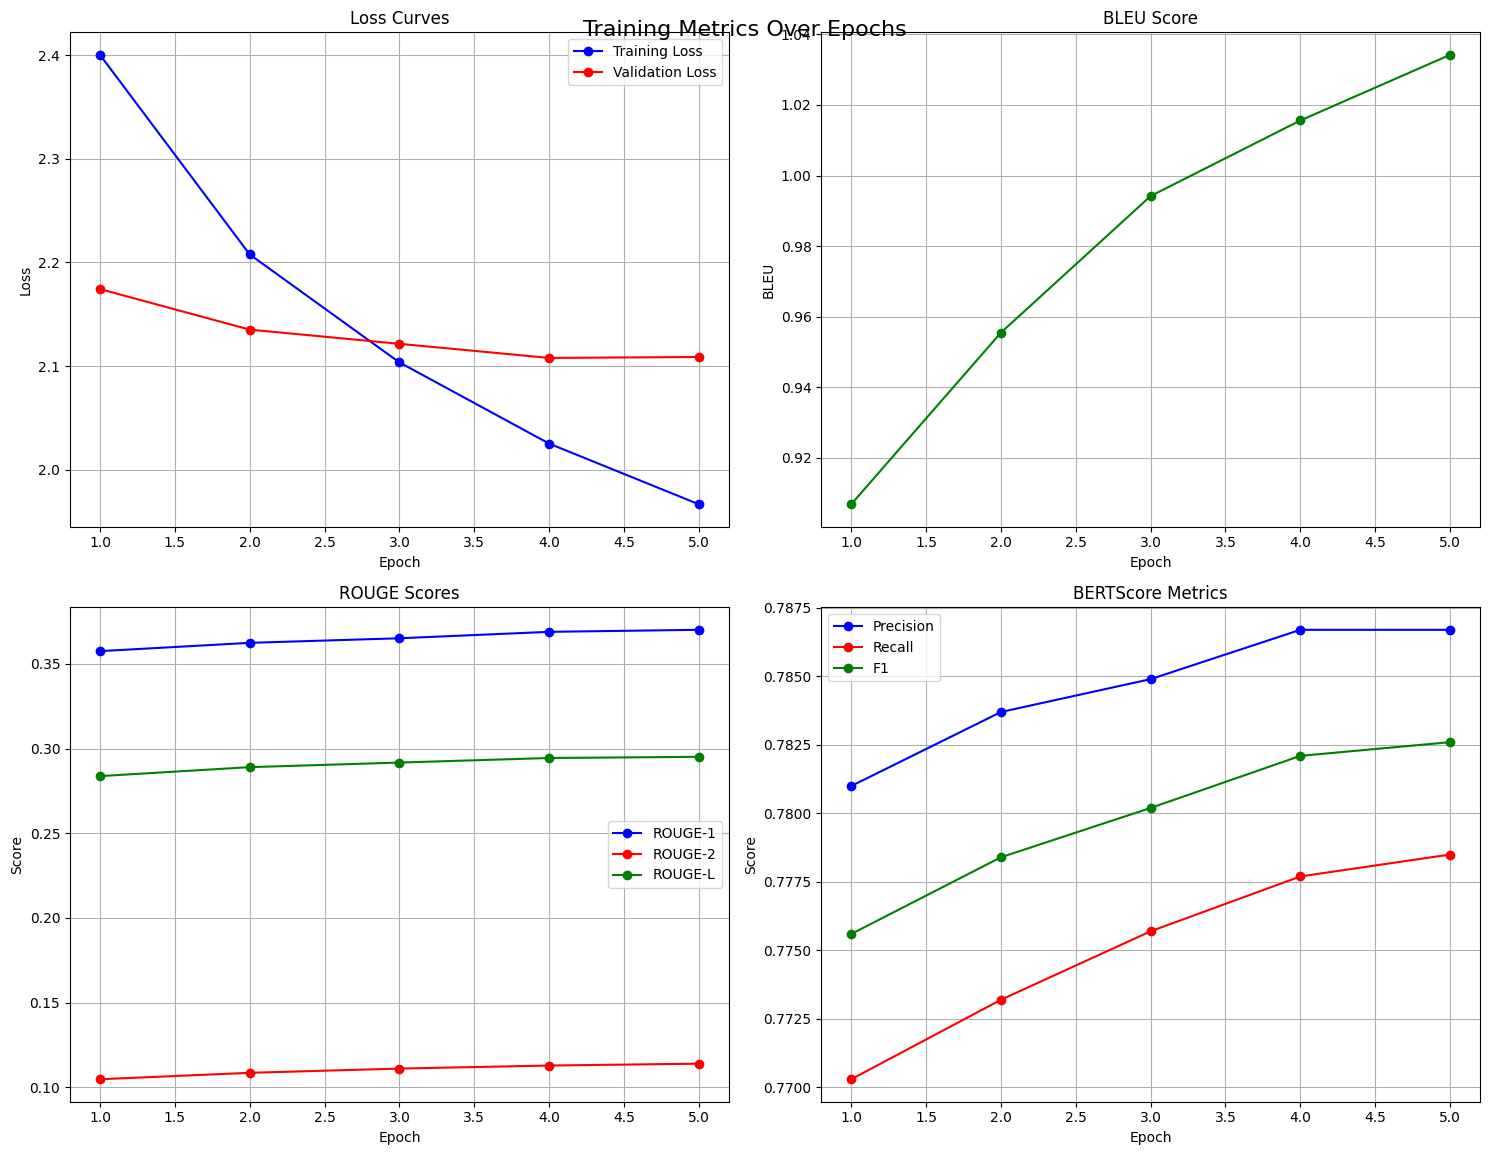

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
epochs = np.arange(1, 6)
train_loss = [2.4002, 2.2077, 2.1036, 2.0253, 1.9668]
val_loss = [2.1743, 2.1352, 2.1215, 2.1079, 2.1088]
bleu = [0.9069, 0.9555, 0.9942, 1.0156, 1.0342]
rouge1 = [0.3575, 0.3624, 0.3651, 0.3689, 0.3701]
rouge2 = [0.1047, 0.1085, 0.1110, 0.1128, 0.1139]
rougeL = [0.2837, 0.2890, 0.2917, 0.2944, 0.2951]
bert_p = [0.7810, 0.7837, 0.7849, 0.7867, 0.7867]
bert_r = [0.7703, 0.7732, 0.7757, 0.7777, 0.7785]
bert_f1 = [0.7756, 0.7784, 0.7802, 0.7821, 0.7826]

# 그래프 설정
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Over Epochs', fontsize=16, y=0.95)

# Loss plot
ax1.plot(epochs, train_loss, 'b-o', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# BLEU score plot
ax2.plot(epochs, bleu, 'g-o')
ax2.set_title('BLEU Score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU')
ax2.grid(True)

# ROUGE scores plot
ax3.plot(epochs, rouge1, 'b-o', label='ROUGE-1')
ax3.plot(epochs, rouge2, 'r-o', label='ROUGE-2')
ax3.plot(epochs, rougeL, 'g-o', label='ROUGE-L')
ax3.set_title('ROUGE Scores')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True)

# BERTScore plot
ax4.plot(epochs, bert_p, 'b-o', label='Precision')
ax4.plot(epochs, bert_r, 'r-o', label='Recall')
ax4.plot(epochs, bert_f1, 'g-o', label='F1')
ax4.set_title('BERTScore Metrics')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Score')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()